In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:

df = pd.read_csv("C:\\Users\\KIIT\\Downloads\\college_student_expenses.csv")  
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", dayfirst=True)
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

df.head()

,Date,Description,Amount,Category,Year,Month
0,2024-11-01,Street food,90.0,Food & Dining,2024,11
1,2024-11-01,Bus fare,30.0,Transport,2024,11
2,2024-11-03,Concert,350.0,Entertainment,2024,11
3,2024-11-04,Printing,20.0,Utilities,2024,11
4,2024-11-04,Milk & dairy,40.0,Groceries,2024,11


In [15]:
# Group data by Month & Category to get total spent per category each month
monthly_spending = df.groupby(["Year", "Month", "Category"])["Amount"].sum().reset_index()
# Display average spending per category
avg_spending_per_category = monthly_spending.groupby("Category")["Amount"].mean().reset_index()
avg_spending_per_category.columns = ["Category", "Avg_Monthly_Spending"]

# Show the results
print("🔹 Average Monthly Spending per Category:")
avg_spending_per_category

🔹 Average Monthly Spending per Category:


,Category,Avg_Monthly_Spending
0,Entertainment,501.8975
1,Food & Dining,998.8575
2,Groceries,405.2775
3,Personal Care,445.6925
4,Shopping,325.0000
5,Transport,225.7100
6,Utilities,196.0000


In [21]:

user_budget = {
    "Food & Dining": 900,
    "Entertainment": 500,
    "Utilities": 200,
    "Personal Care": 600,
    "Transport": 200,
    "Groceries": 400
}

# Convert to DataFrame for easy comparison
df_budget = pd.DataFrame(list(user_budget.items()), columns=["Category", "User_Budget"])

# Merge user budget with average spending
budget_comparison = avg_spending_per_category.merge(df_budget, on="Category", how="left")

# Calculate Over/Under Budget
budget_comparison["Difference"] = budget_comparison["Avg_Monthly_Spending"] - budget_comparison["User_Budget"]
budget_comparison["Status"] = budget_comparison["Difference"].apply(lambda x: "Overspending" if x > 0 else "Within Budget")

# Display the results
print("🔹 Budget vs Spending Comparison:")
budget_comparison


🔹 Budget vs Spending Comparison:


,Category,Avg_Monthly_Spending,User_Budget,Difference,Status
0,Entertainment,501.8975,500.0,1.8975,Overspending
1,Food & Dining,998.8575,900.0,98.8575,Overspending
2,Groceries,405.2775,400.0,5.2775,Overspending
3,Personal Care,445.6925,600.0,-154.3075,Within Budget
4,Shopping,325.0000,NaN,NaN,Within Budget
5,Transport,225.7100,200.0,25.7100,Overspending
6,Utilities,196.0000,200.0,-4.0000,Within Budget


In [27]:
monthly_spending = df.groupby(["Year", "Month", "Category"])["Amount"].sum().reset_index()

# Pivot to get categories as columns
data_pivot = monthly_spending.pivot_table(index=["Year", "Month"], columns="Category", values="Amount", fill_value=0)


X = data_pivot.iloc[:-1]  # All months except last (for training)
y = data_pivot.iloc[1:]   # Next month's spending (for prediction)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

X_last_month = pd.DataFrame([X.iloc[-1]], columns=X.columns)


predicted_budget = model.predict(X_last_month)  # Predict based on last available month
predicted_budget_df = pd.DataFrame(predicted_budget, columns=data_pivot.columns)



📌 Predicted Budget for Next Month:
Category  Entertainment  Food & Dining  Groceries  Personal Care  Shopping  \
0              400.6688      1179.9508      401.9       398.1638     222.0   

Category  Transport  Utilities  
0          182.3804     259.16  

📌 User's Input Budget:
   Food & Dining  Entertainment  Utilities  Personal Care  Transport  \
0            900            500        200            600        200   

   Groceries  
0        400  

📌 Budget Comparison:
             Entertainment  Food & Dining  Groceries  Personal Care  Shopping  \
Predicted         400.6688      1179.9508      401.9       398.1638     222.0   
User Budget       500.0000       900.0000      400.0       600.0000       NaN   

             Transport  Utilities  
Predicted     182.3804     259.16  
User Budget   200.0000     200.00  

⚠️ Overspending Analysis:
               Difference
Food & Dining    279.9508
Groceries          1.9000
Utilities         59.1600


<Figure size 1000x500 with 0 Axes>

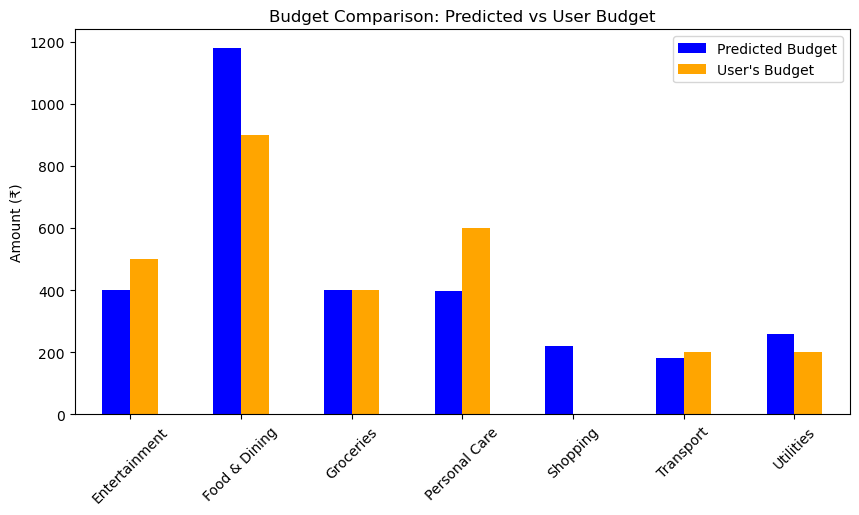

In [43]:
user_budget_df = pd.DataFrame([user_budget])

comparison = pd.concat([predicted_budget_df, user_budget_df], axis=0)
comparison.index = ["Predicted", "User Budget"]

# 8️⃣ Display Budget Plan & Recommendations
print("\n📌 Predicted Budget for Next Month:")
print(predicted_budget_df)

print("\n📌 User's Input Budget:")
print(user_budget_df)

print("\n📌 Budget Comparison:")
print(comparison)

# Highlight overspending areas
overspending = predicted_budget_df - user_budget_df
overspending = overspending.T
overspending.columns = ["Difference"]

print("\n⚠️ Overspending Analysis:")
print(overspending[overspending["Difference"] > 0])

# 9️⃣ Plot Budget Comparison
plt.figure(figsize=(10,5))
comparison.T.plot(kind='bar', figsize=(10,5), color=['blue', 'orange'])
plt.title("Budget Comparison: Predicted vs User Budget")
plt.ylabel("Amount (₹)")
plt.xticks(rotation=45)
plt.legend(["Predicted Budget", "User's Budget"])
plt.show()